# Healthcare Case Studies Report
- Darshil Desai, Edwin Ramirez, Rashi Saxena

(D combined with rupdate) 5/1/19

<h1 id="tocheading">Table of Contents</h1>
<br>
<div id="toc">

<h2> test </h2>

</div>

In [3]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')
// Run this to refresh the table of contents

<IPython.core.display.Javascript object>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import f_classif, chi2, SelectKBest
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score,roc_auc_score, mean_squared_error
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from scipy.stats import chi2_contingency
from scipy import stats

import seaborn as sns
import re

from stepwise_regression import stepwise_regression  # !pip install stepwise-regression
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

ModuleNotFoundError: No module named 'stepwise_regression'

# Project Overview

In this project we dive deep into the depths of the healthcare dataset and explore insightful relationships between the different types of data provided and pursue building predictive models




We will be predicting: 
- Regression: Predict post_medical_cost
- Classifications - Logistic, KNN and NB: to predict pdc_80_flag

# Exploring the Dataset

Before we dive deeper into model building, we need to explore our dataset. [ADD MORE]


In [5]:
# Reading in the data file
data = pd.read_csv('projectTrain.csv')
data.head()

,pdc,num_ip_post,total_los_post,num_op_post,num_er_post,num_ndc_post,num_gpi6_post,adjust_total_30d_post,generic_rate_post,post_ip_flag,...,generic_cost,brand_cost,ratio_G_total_cost,numofgen_post,numofbrand_post,generic_cost_post,brand_cost_post,ratio_G_total_cost_post,pdc_80_flag,drug_class
0,0.333333,0,0,4,0,15,5,14.466667,0.101382,0,...,30.621563,2984.927229,0.010155,2,13,196.359216,3001.501507,0.061403,0,*ANTIDIABETICS*
1,0.866667,0,0,5,0,16,4,18.000000,0.888889,0,...,720.788173,0.000000,1.000000,14,2,671.755173,735.661568,0.477297,1,*ANTIDIABETICS*
2,0.938889,0,0,7,0,11,4,8.600000,1.000000,0,...,179.538533,0.000000,1.000000,11,0,171.446621,0.000000,1.000000,1,*ANTICOAGULANTS*
3,0.077778,1,12,40,0,5,5,2.033333,1.000000,1,...,105.816329,0.000000,1.000000,5,0,335.826436,0.000000,1.000000,0,*ANTICOAGULANTS*
4,0.444444,0,0,12,1,15,9,14.833333,0.528090,0,...,630.173638,3265.595950,0.161758,8,7,75.988845,2054.400835,0.035669,0,*ANTIDIABETICS*


In [4]:
# Taking a look at the data dimensions
print ('This dataset has {} records and {} features'.format(data.shape[0], data.shape[1]))

This dataset has 2000 records and 94 features


In [5]:
# Features in focus
print ('Predictor variable for the regression problem: post_medical_cost & for the classification problem: pdc_80_flag' )

Predictor variable for the regression problem: post_medical_cost & for the classification problem: pdc_80_flag


## Creating Datasets

In this section we will subset the dataframe and select the features we deem appropriate to further this analysis. Note that these features are not final and among these features there will be several that will not be selected for the machine learning models. In the "Feature Selection" section of this project, we will employ the use of various statistical techniques to determine the appropriateness of the same. 

In [6]:
def create_data(problem_type, data):
    """        
    Returns the continuous AND categorical datasets for either the categorical or continuous problem
    
    Parameters
    -------------
    : problem_type: enter either 'class' for classification or 'reg' for regression
    : data: the raw dataset provided to us    
    
    Returns
    ---------
    2 PROCESSED dataframes. First one being the continuous features and the other being categorical features. 
    
    Example:
    ----------
    - Data needed for classification
    >>> continuous_variables_for_classification_dataframe = create_data('class', data = data)[0]
    >>> categorical_variables_for_classification_dataframe = create_data('class', data = data)[1]
    
    - Data needed for regression
    >>> continuous_variables_for_regression_dataframe = create_data('reg', data = data)[0]
    >>> categorical_variables_for_regression_dataframe = create_data('reg', data = data)[1]        
    
    You can then combine them into one training data and use it accordingly. 
    >>> training_data_regression = pd.concat([continuous_variables_for_regression_dataframe, categorical_variables_for_regression_dataframe], 1)
    """    
        
    #-----------------------------------

    if problem_type == 'class':
        """Subsetting the dataset to account for diabetic patients only for classification"""
        data1 = data[data['drug_class'].str.contains('ANTIDIABETIC')]
    
    if problem_type == 'reg':
        """Subsetting the dataset to account for diabetic patients only for classification"""
        data1 = data                

    #-----------------------------------
    """Creating the Continous variables"""
    first_cont = data1.iloc[:,0:19]
    other_cont = data1.iloc[:,62:92]

    # Combine the get all the continuous variables
    cont_features = pd.concat([first_cont,other_cont ],axis=1)

    # Selecting all columns that dont have the word "post" in it
    cont_features = cont_features[cont_features.columns[[not i for i in [bool(re.search('post', x)) for x in cont_features.columns]]]]

    #-----------------------------------
    """Categorical variables"""

    # Subsetting the different types of categorical columns
    all_diseases = data1.iloc[:,26:61]  # Diseases
    othercats = data1.iloc[:,19:22]  # Other categories like region, Sex, PCI etc
    cat_features = pd.concat([all_diseases,othercats ],axis=1)  # Combine all categorical variables into one dataframe

    cat_features1 = cat_features  # Rereate for safety

    # Initialize an empty list to append select all columns that will be one-hot-encoded
    u_cols = []

        # --------------------------------------

    # For each column check if number of unique values > 2, if so one-hotcode them
    for x in cat_features1.columns:

        # Chrck if number of unque values in column is greater than 2
        if (len(cat_features1[x].value_counts().index)) >2:  
            # print (x, len(cat_features1[x].value_counts().index))

            # Append to empty list if num of unique values in list is > 2
            u_cols.append(x)

            # Create dummy variables for the x column
            dummy = pd.get_dummies(pd.get_dummies(cat_features1[x], prefix = '{}'.format(x)))

            # Append dummy variables to the main  
            cat_features1 = pd.concat([cat_features1, dummy], axis=1)

    # Keep only the dummy variables, remove the original variable
    use_cols = [x for x in cat_features1.columns if x not in u_cols ]

    # Finally subset the categorical variables and use only dummy variables
    cat_features1 = cat_features1[use_cols]

    # --------------------------------------
    return cont_features, cat_features1            
    # --------------------------------------
                

###  (A) Classification Dataset

In this section we will employ the use of manual feature selection to select relevant features that are required for predicting the pdc_80_flag.

- **a. Antidiabetics Only:** The classification problem requires a model trained only on Antidiabetic patients. Therefore, we will subset the dataset accordingly


- **b. Selecting continuous features:** Although there are no explicit requirements for selecting the relevant continuous variables, it is important to note that because we are predicting the proportion of days covered (follow up) , it would be more appropriate to limit our continuous features to the pre-index range


- **c. Selecting categorical features:** We will begin my selecting all the categorical features that are present. Furthermore, there lies a need to transform categorical features into dummy variables in the event that a categorical variable has more than 2 values

In [7]:
# Creating our dataset for the classification problem
class_cont_vars = create_data('class', data = data)[0]
class_categorical_vars = create_data('class', data = data)[1]

In [8]:
class_cont_vars.head(2)

,pdc,pdc_cat,idx_copay,pre_er_cost,pre_rx_cost,pre_op_cost,pre_total_cost,pre_medical_cost,num_ip,total_los,...,log_pre_ip_cost,log_pre_er_cost,log_pre_op_cost,log_pre_rx_cost,pre_total_cat,numofgen,numofbrand,generic_cost,brand_cost,ratio_G_total_cost
0,0.333333,3,40.474500,0.0,3015.548793,1626.271037,4641.819829,1626.271037,0,0,...,-4.60517,-4.60517,7.394045,8.011537,7,2,13,30.621563,2984.927229,0.010155
1,0.866667,1,4.060471,0.0,720.788173,479.349400,1200.137573,479.349400,0,0,...,-4.60517,-4.60517,6.172430,6.580345,4,17,0,720.788173,0.000000,1.000000


In [9]:
class_categorical_vars.head(2)

,ALCOHOL_DRUG,ASTHMA,CARDIAC_ARRYTHMIA,CARDIAC_VALVULAR,CEREBROVASCULAR,CHRONIC_KIDNEY,CHRONIC_PAIN_FIBRO,CHF,COPD,DEMENTIA,...,pre_CCI_7,pre_CCI_8,pre_CCI_10,age_grpN_2,age_grpN_3,age_grpN_4,regionN_1,regionN_2,regionN_3,regionN_4
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [10]:
class_cont_vars.columns

Index(['pdc', 'pdc_cat', 'idx_copay', 'pre_er_cost', 'pre_rx_cost',
       'pre_op_cost', 'pre_total_cost', 'pre_medical_cost', 'num_ip',
       'total_los', 'num_op', 'num_er', 'num_ndc', 'num_gpi6',
       'adjust_total_30d', 'generic_rate', 'pre_ip_flag', 'pre_er_flag',
       'log_pre_ip_cost', 'log_pre_er_cost', 'log_pre_op_cost',
       'log_pre_rx_cost', 'pre_total_cat', 'numofgen', 'numofbrand',
       'generic_cost', 'brand_cost', 'ratio_G_total_cost'],
      dtype='object')

###  (B) Regression Dataset

In this section we will employ the use of manual feature selection to select relevant features that are required for predicting the pdc_80_flag.

- **a. All patients:** The classification problem required a model trained only on Antidiabetic patients. For the purpose of predicting the post_total_cost we will employ the use of 


- **b. Selecting continuous features:** It is important to note that because we are predicting the proportion of days covered (follow up) , it would be more appropriate to limit our continuous features to the pre-index range


- **c. Selecting categorical features:** We will begin my selecting all the categorical features that are present. Furthermore, there lies a need to transform categorical features into dummy variables in the event that a categorical variable has more than 2 values

In [11]:
# Creating our dataset for the regression problem
reg_cont_vars = create_data('reg', data = data)[0]
reg_categorical_vars = create_data('reg', data = data)[1]

In [12]:
reg_cont_vars.head(2)

,pdc,pdc_cat,idx_copay,pre_er_cost,pre_rx_cost,pre_op_cost,pre_total_cost,pre_medical_cost,num_ip,total_los,...,log_pre_ip_cost,log_pre_er_cost,log_pre_op_cost,log_pre_rx_cost,pre_total_cat,numofgen,numofbrand,generic_cost,brand_cost,ratio_G_total_cost
0,0.333333,3,40.474500,0.0,3015.548793,1626.271037,4641.819829,1626.271037,0,0,...,-4.60517,-4.60517,7.394045,8.011537,7,2,13,30.621563,2984.927229,0.010155
1,0.866667,1,4.060471,0.0,720.788173,479.349400,1200.137573,479.349400,0,0,...,-4.60517,-4.60517,6.172430,6.580345,4,17,0,720.788173,0.000000,1.000000


In [13]:
reg_categorical_vars.head(2)

,ALCOHOL_DRUG,ASTHMA,CARDIAC_ARRYTHMIA,CARDIAC_VALVULAR,CEREBROVASCULAR,CHRONIC_KIDNEY,CHRONIC_PAIN_FIBRO,CHF,COPD,DEMENTIA,...,pre_CCI_8,pre_CCI_9,pre_CCI_10,age_grpN_2,age_grpN_3,age_grpN_4,regionN_1,regionN_2,regionN_3,regionN_4
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


### (C) Visual Exploratory Data Exploration

Now that we have our datsets, lets examine the structure and distribution of the different types of data within these datasets

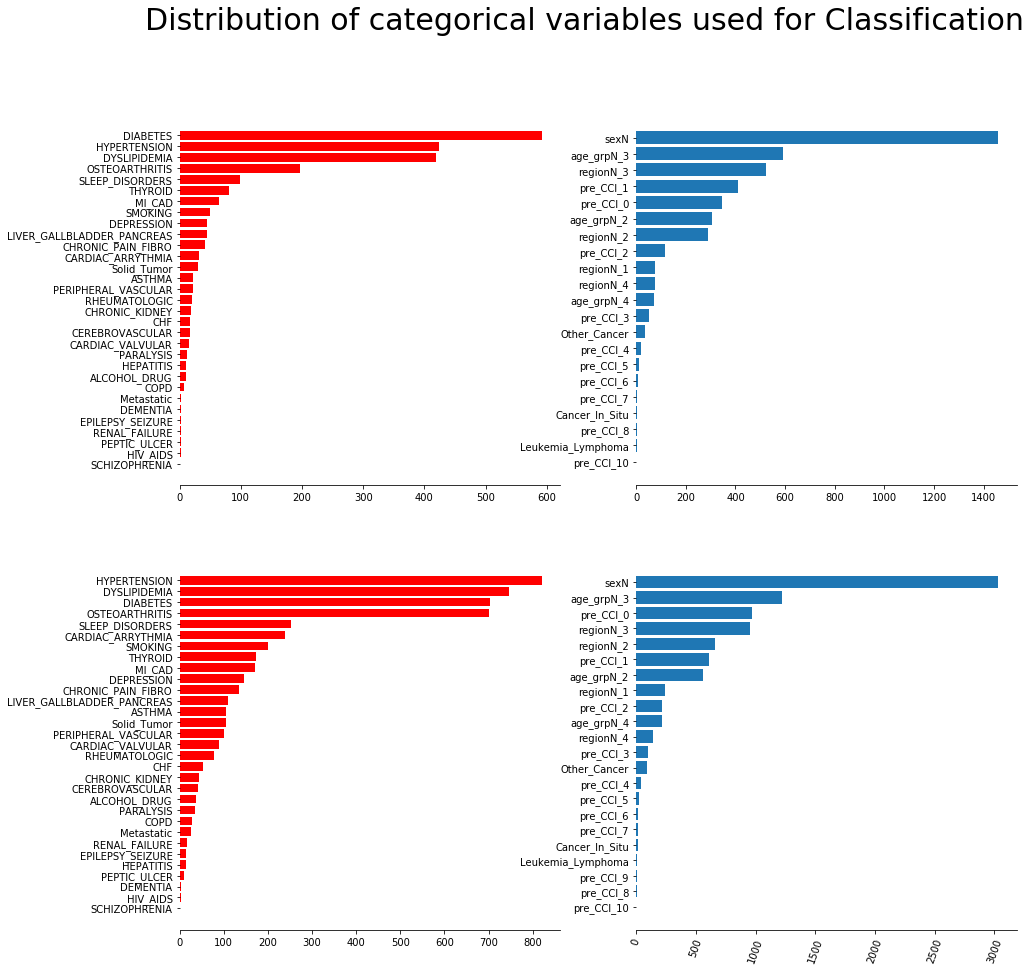

In [14]:

plt.figure(figsize=(15,15))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.suptitle('Distribution of categorical variables used for Classification', fontsize=30)

#-------------------------------------------

# Plotting the predictor variable to convey class balance or imbalance
# Taking a look at our categorical variables
plt.subplot(2,2,1)

z = pd.DataFrame(class_categorical_vars.iloc[:,0:31].sum())
z.columns = ['counts']
z = z.sort_values('counts',ascending=True)
plt.barh(z.index, z.counts, color = 'red')

#-------------------------------------------

# Plotting the predictor variable to convey class balance or imbalance
# Taking a look at our categorical variables
plt.subplot(2,2,2)

z1 = pd.DataFrame(class_categorical_vars.iloc[:,31:].sum())
z1.columns = ['counts']
z1 = z1.sort_values('counts',ascending=True)
plt.barh(z1.index, z1.counts)

# Plotting the predictor variable to convey class balance or imbalance
# Taking a look at our categorical variables
plt.subplot(2,2,3)

z = pd.DataFrame(reg_categorical_vars.iloc[:,0:31].sum())
z.columns = ['counts']
z = z.sort_values('counts',ascending=True)
plt.barh(z.index, z.counts, color = 'red')

#-------------------------------------------

# Plotting the predictor variable to convey class balance or imbalance
# Taking a look at our categorical variables
plt.subplot(2,2,4)

z1 = pd.DataFrame(reg_categorical_vars.iloc[:,31:].sum())
z1.columns = ['counts']
z1 = z1.sort_values('counts',ascending=True)
plt.barh(z1.index, z1.counts)
plt.xticks(rotation=70)


sns.despine(left=True)

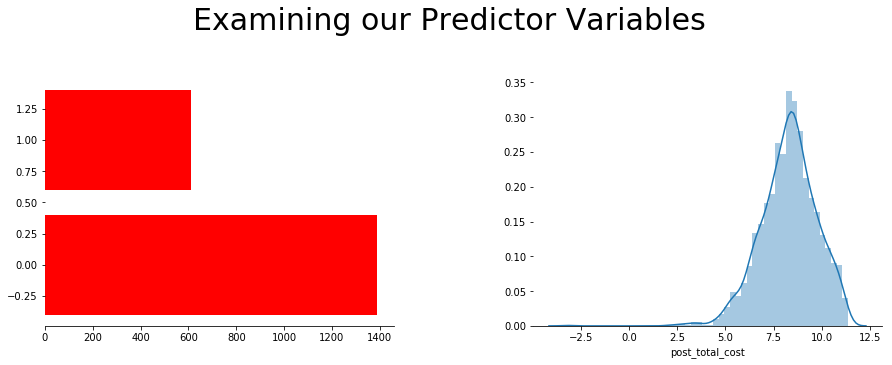

In [18]:
# Taking a look at our predictor variables

plt.figure(figsize=(15,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)
plt.suptitle('Examining our Predictor Variables', fontsize=30)

#-------------------------------------------

# Plotting the predictor variable to convey class balance or imbalance
plt.subplot(2,2,1)

a = pd.DataFrame(data.groupby(data.pdc_80_flag)['pdc_80_flag'].count())
plt.barh(list(a.index),a.pdc_80_flag, color = 'red')

#-------------------------------------------
# Plotting the predictor variable to convey class balance or imbalance
plt.subplot(2,2,2)
sns.distplot(np.log(data['post_total_cost']), label="Actual High")  # Log transforming the post_total_cost 

sns.despine(left=True)

Text(0.5, 1.0, 'Primary Payer Type with Total Medical Cost')

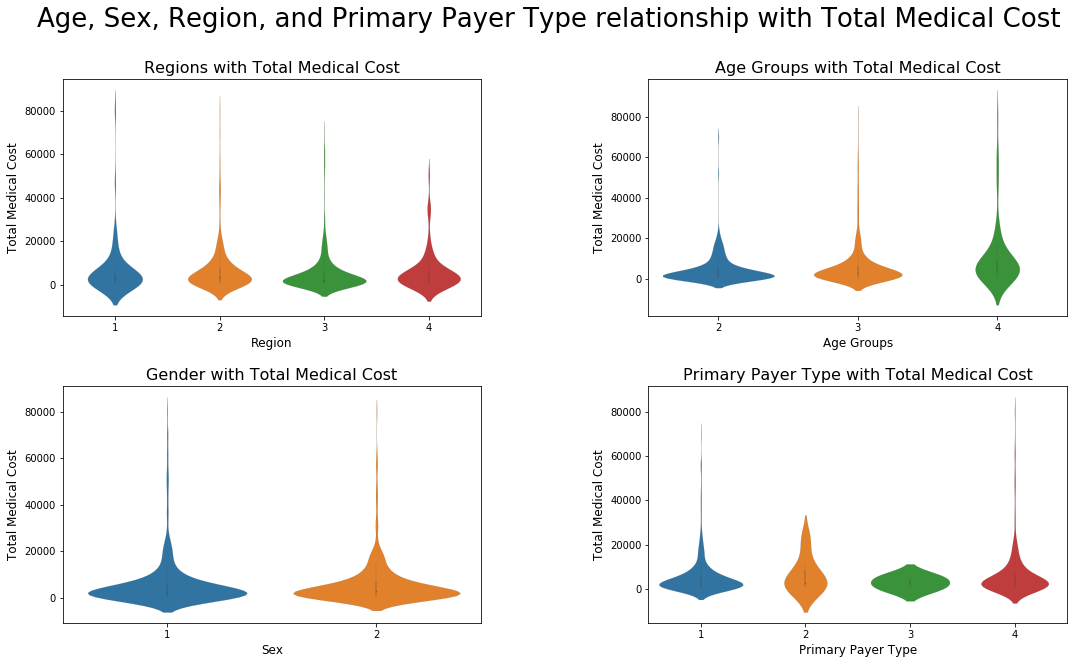

In [36]:
#Taking a look at Age, Sex, Region, and Primary Payer Type relationship with Total Medical Cost


plt.figure(figsize=(18,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.3)

plt.suptitle('Age, Sex, Region, and Primary Payer Type relationship with Total Medical Cost', fontsize=26)

#-------------------------------------------
plt.subplot(2,2,1)

sns.violinplot(x=data1.regionN, y= data['post_total_cost'], linewidth=0.1)
plt.xlabel('Region',fontsize = 12)
plt.ylabel('Total Medical Cost',fontsize = 12)
plt.title('Regions with Total Medical Cost',fontsize = 16)

#-------------------------------------------
plt.subplot(2,2,2)


sns.violinplot(x=data1.age_grpN, y=data['post_total_cost'], linewidth=0.1)
plt.xlabel('Age Groups',fontsize = 12)
plt.ylabel('Total Medical Cost',fontsize = 12)
plt.title('Age Groups with Total Medical Cost',fontsize = 16)
#-------------------------------------------
plt.subplot(2,2,3)


sns.violinplot(x=data1.sexN, y=data['post_total_cost'], linewidth=0.1)
plt.xlabel('Sex',fontsize = 12)
plt.ylabel('Total Medical Cost',fontsize = 12)
plt.title('Gender with Total Medical Cost',fontsize = 16)

#--------------------------------------------

plt.subplot(2,2,4)


sns.violinplot(x=data1.idx_paytypN, y=data['post_total_cost'], linewidth=0.1)
plt.xlabel('Primary Payer Type',fontsize = 12)
plt.ylabel('Total Medical Cost',fontsize = 12)
plt.title('Primary Payer Type with Total Medical Cost',fontsize = 16)

Here we are taking a closer look at four of our categorical variables relationship with our predictor variable, total medical cost.

`Region`- 1(Northeast), 2(Midwest), 3(South), and 4(West). We can see that the distributions are pretty similar through the regions. We also notice that there are a lot of outliers in regions in all the regions. This may be something we are interested in checking further and eliminating from our data for our models. We can also see that the average total medical cost is different in different regions, showing us that this may be a good variable to use when predicting the total medical cost. 

`Age Groups`- 1(0 - 18 years), 2(19 - 44 years), 3(45 - 64 years), 4(65+ years). We notice a few things in this plot- 1) that there is no data present for the age group from 0-18 years, 2) there are a lot of outliers present in each age group, 3) the average total medical cost is pretty similar for age group 2,3, but different for age group 4. Groups 2 and 3 have a similar distribution vs group 4 is a bit different than the other groups. 

`Gender` - 1(Male), 2(Female) - We see that there are a lot of outliers in in both Male and Female groups. We can also see that the average total medical cost seems very similar between the both groups and that both groups also have a similar distribution. 

`Primary Payer Type` - 1(Commercial), 2(Medicaid), 3(Medicare), 4(Self-Insured). We can there are a lot of outliers in Type 1 and Type 4. We can also observe the difference in the average total medical cost in the different primary payer types along with huge different in the distributions for the different levels of primary payer type through the total medical cost. 





In [37]:
data1 = data[data['drug_class'].str.contains('ANTIDIABETIC')]

No handles with labels found to put in legend.


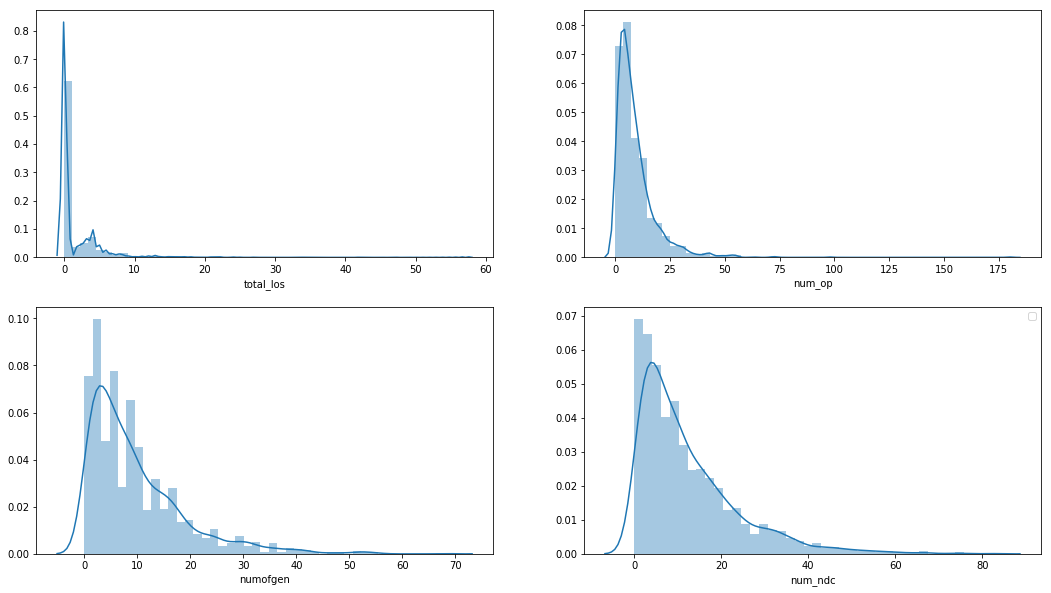

In [54]:
plt.figure(figsize=(18,10))

#-------------------------------------------
plt.subplot(2,2,1)

plot_high = sns.distplot(data.total_los)

#-------------------------------------------
plt.subplot(2,2,2)

plot_low = sns.distplot(data.num_op)

#-------------------------------------------
plt.subplot(2,2,3)


plot_mel = sns.distplot(data.numofgen)

#--------------------------------------------

plt.subplot(2,2,4)

plot_rum = sns.distplot(data.num_ndc)

plt.legend()
plt.show()

We are comparing the distributions for a few our continuous variables that we think will have a strong relationship with both our predictor variables, pdc_80_flag and post_total_cost.  We can see that all four of the continuous features are skewed.
`total_los` - this variable is number of total inpatient days, pre-index. <br>
`num_op` - this variable is the number of total outpatient visits, pre-index. <br>
`numofgen` - this variable is the number of gGeneric scripts filled, pre-index. <br>
`num_ndc` - this variable is the number of total number of prescriptions


# Regression - Feature Selection

## (A) Collinearity Tests

In this section we will employ the use of a correlation matrix to determine the following: 

**- (i.) Multicollinearity: ** Determine whether the continous independent variables, which we will use to predict both the **post_total_cost** posed as a regression problem, are independent of one another. Given the high dimensionality of our dataset, it is completely plausible for features to correlate with one another and moving forward without fixing this phenomenon will render the predictive model inaccurate and irrelevant

**- (ii.) Correlation between independent vars and predictor variables** Determine whether there exists a significant collinearity between the feature set and the variable we are trying to predict. In simple works, this allows us to answer to confirm that there indeed lies some type of "relationship" between what we are trying to predict and what we are using to predict!

**- (iii.) Comparative T-Test:** In order to find the categorical variables that have would be valuable factors for us to use in our regression model, that is to predict the total medical costs, we will employ the use of comparative T-Tests to compare the the median post total cost for patients that have a disease(1) differs from the median total cost for patients that do not have a disease(0) for different variables. We will start with some simple boxplots to examine these differences, if any, visually

###  Multicollinearity

In order to observe multi-colinearity we need to take into account the **post_total_cost** variable. Since we only have the cpontiouos and categorical variables for the regression problem, there lies a need to combine this feature set with the **post_total_cost** from the raw dataset (after correctly indexing ofcourse)

In [17]:
# Creating a dataset to measure multi-collinearity between the continuous variables in the regression feature set
#.... vs the post_total_cost variable
reg_data_multicolin =  pd.concat([reg_cont_vars, pd.DataFrame(data['post_total_cost'])],1)

In [18]:
reg_data_multicolin.columns

Index(['pdc', 'pdc_cat', 'idx_copay', 'pre_er_cost', 'pre_rx_cost',
       'pre_op_cost', 'pre_total_cost', 'pre_medical_cost', 'num_ip',
       'total_los', 'num_op', 'num_er', 'num_ndc', 'num_gpi6',
       'adjust_total_30d', 'generic_rate', 'pre_ip_flag', 'pre_er_flag',
       'log_pre_ip_cost', 'log_pre_er_cost', 'log_pre_op_cost',
       'log_pre_rx_cost', 'pre_total_cat', 'numofgen', 'numofbrand',
       'generic_cost', 'brand_cost', 'ratio_G_total_cost', 'post_total_cost'],
      dtype='object')

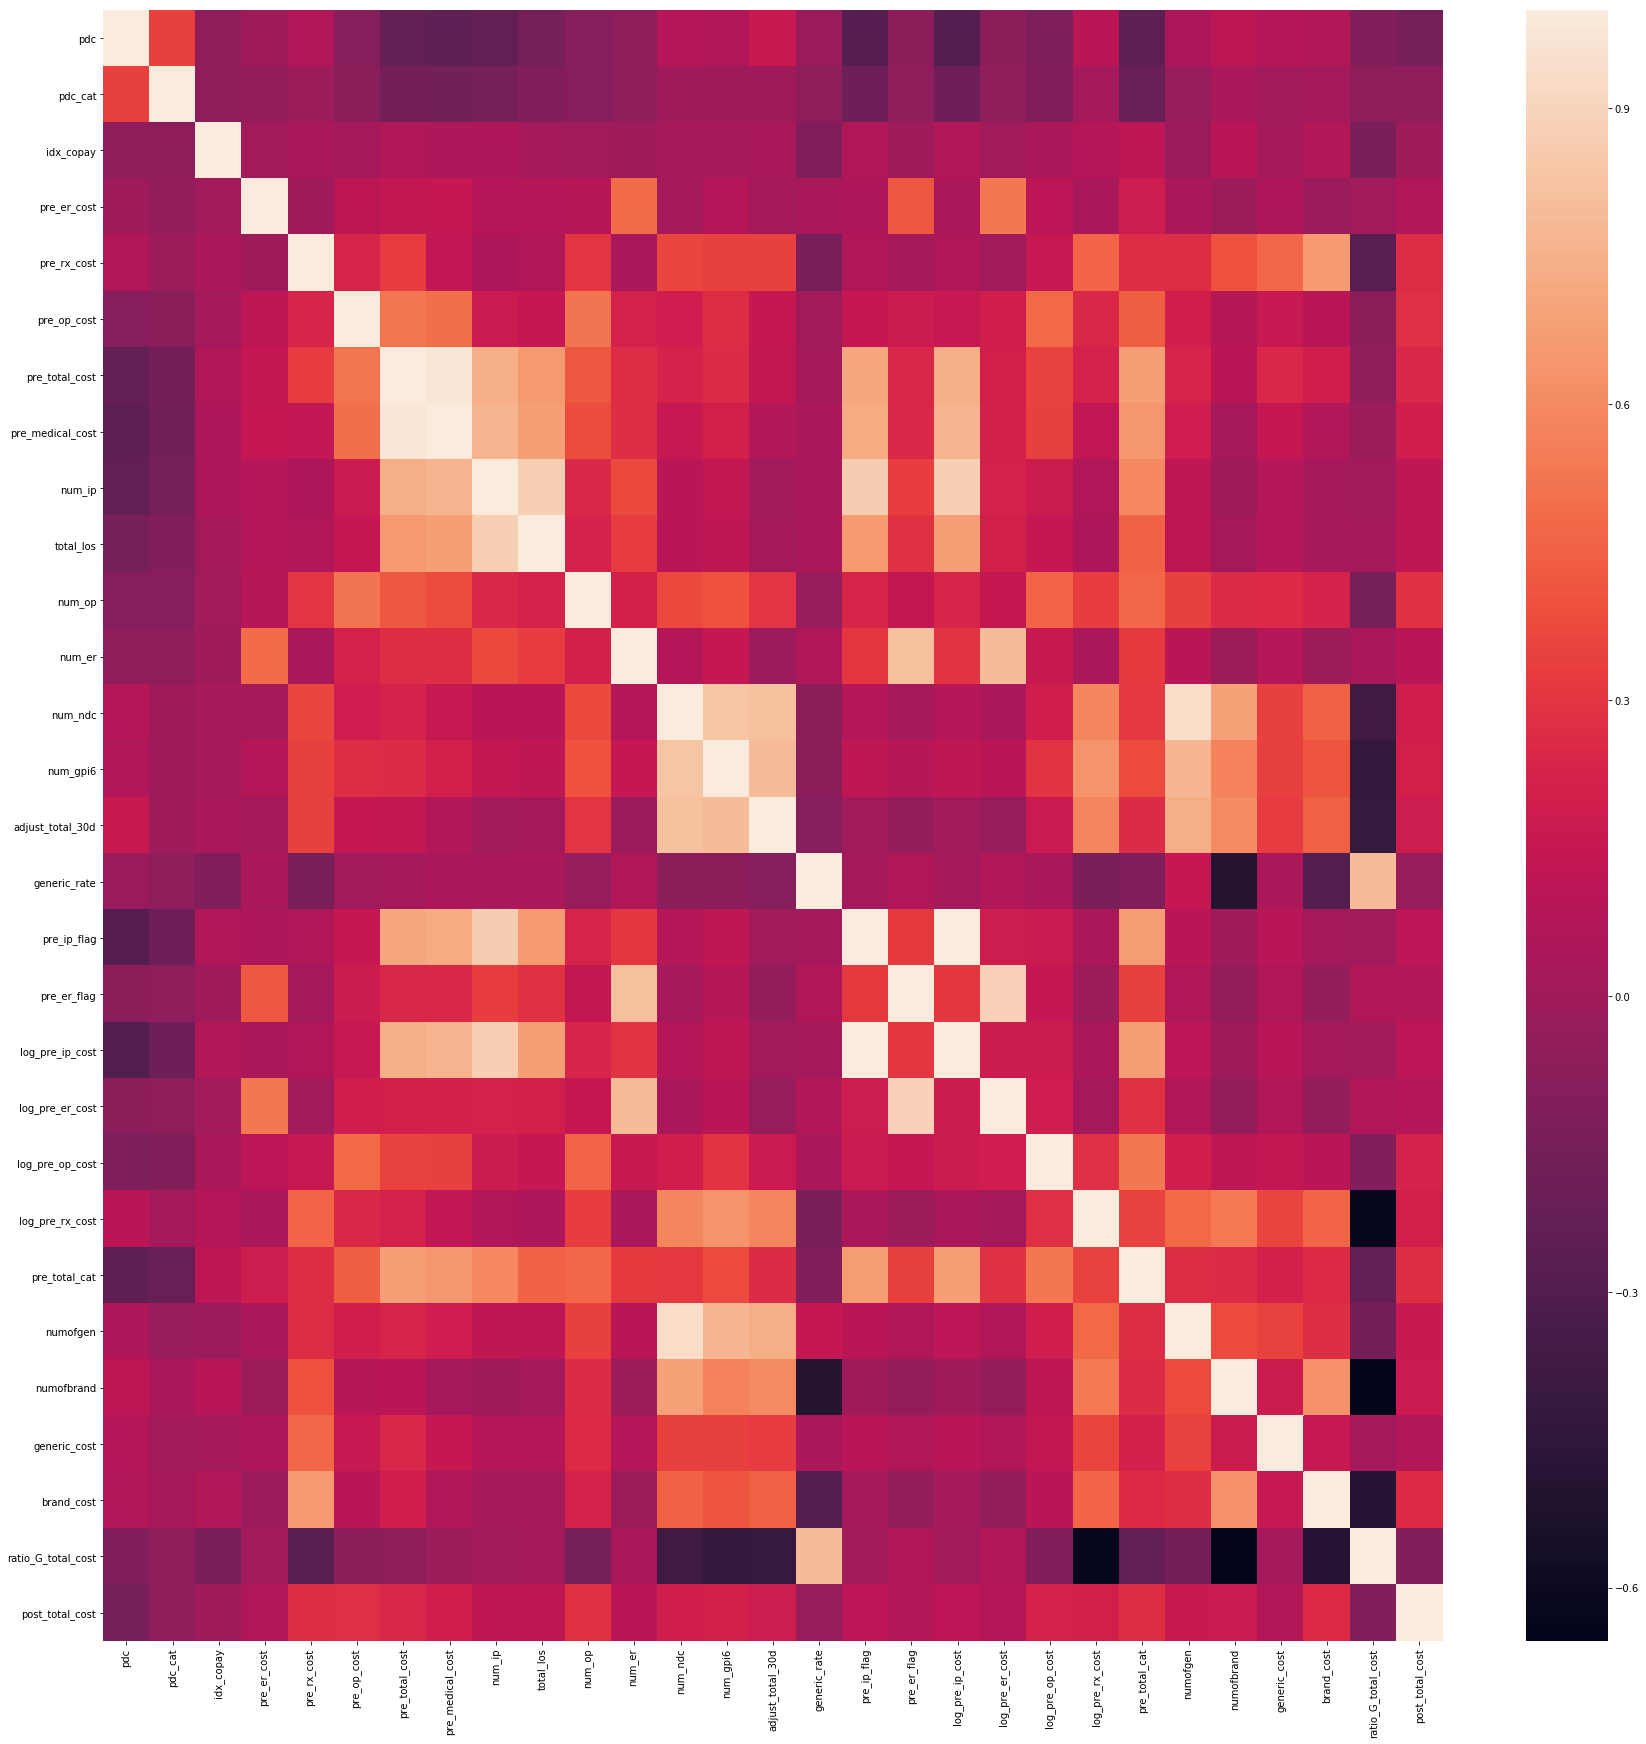

In [19]:
plt.figure(figsize=(30,30))
corr = reg_data_multicolin.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values) ;

**Next,** lets observe the above phenomenon numerically. Given below are the R^2 values that allow us to see how well numerical values correlate with one another. Recall that a good set of features are independent of one another

In [20]:
cor_matrix = reg_data_multicolin.corr()
cor_matrix.head(5)

,pdc,pdc_cat,idx_copay,pre_er_cost,pre_rx_cost,pre_op_cost,pre_total_cost,pre_medical_cost,num_ip,total_los,...,log_pre_er_cost,log_pre_op_cost,log_pre_rx_cost,pre_total_cat,numofgen,numofbrand,generic_cost,brand_cost,ratio_G_total_cost,post_total_cost
pdc,1.000000,0.341591,-0.058619,-0.006364,0.058645,-0.087541,-0.225819,-0.248723,-0.235985,-0.150989,...,-0.066916,-0.128328,0.104936,-0.241414,0.053872,0.116396,0.082020,0.070601,-0.101133,-0.154861
pdc_cat,0.341591,1.000000,-0.056841,-0.046401,-0.007951,-0.083604,-0.160923,-0.166922,-0.151466,-0.105001,...,-0.053942,-0.113994,0.019176,-0.208682,-0.023211,0.043687,0.010557,0.012129,-0.053769,-0.055482
idx_copay,-0.058619,-0.056841,1.000000,0.010053,0.038715,0.013279,0.059075,0.053849,0.051249,0.023157,...,0.009803,0.044617,0.083538,0.118514,-0.014657,0.100952,0.019877,0.076131,-0.134293,0.003074
pre_er_cost,-0.006364,-0.046401,0.010053,1.000000,0.001647,0.118528,0.139574,0.145867,0.085313,0.087270,...,0.534753,0.110547,0.037106,0.181174,0.038104,-0.008949,0.051707,-0.018656,0.006352,0.064399
pre_rx_cost,0.058645,-0.007951,0.038715,0.001647,1.000000,0.235396,0.322903,0.130729,0.054448,0.057310,...,0.009556,0.158766,0.457711,0.266932,0.265368,0.403704,0.476390,0.660848,-0.272123,0.267493


In [21]:
"""This section drops continous variable that are highly correlated"""

# Upper triangle of correlation matrix
upper = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
upper.head(5)

,pdc,pdc_cat,idx_copay,pre_er_cost,pre_rx_cost,pre_op_cost,pre_total_cost,pre_medical_cost,num_ip,total_los,...,log_pre_er_cost,log_pre_op_cost,log_pre_rx_cost,pre_total_cat,numofgen,numofbrand,generic_cost,brand_cost,ratio_G_total_cost,post_total_cost
pdc,NaN,0.341591,-0.058619,-0.006364,0.058645,-0.087541,-0.225819,-0.248723,-0.235985,-0.150989,...,-0.066916,-0.128328,0.104936,-0.241414,0.053872,0.116396,0.082020,0.070601,-0.101133,-0.154861
pdc_cat,NaN,NaN,-0.056841,-0.046401,-0.007951,-0.083604,-0.160923,-0.166922,-0.151466,-0.105001,...,-0.053942,-0.113994,0.019176,-0.208682,-0.023211,0.043687,0.010557,0.012129,-0.053769,-0.055482
idx_copay,NaN,NaN,NaN,0.010053,0.038715,0.013279,0.059075,0.053849,0.051249,0.023157,...,0.009803,0.044617,0.083538,0.118514,-0.014657,0.100952,0.019877,0.076131,-0.134293,0.003074
pre_er_cost,NaN,NaN,NaN,NaN,0.001647,0.118528,0.139574,0.145867,0.085313,0.087270,...,0.534753,0.110547,0.037106,0.181174,0.038104,-0.008949,0.051707,-0.018656,0.006352,0.064399
pre_rx_cost,NaN,NaN,NaN,NaN,NaN,0.235396,0.322903,0.130729,0.054448,0.057310,...,0.009556,0.158766,0.457711,0.266932,0.265368,0.403704,0.476390,0.660848,-0.272123,0.267493


In [22]:
# In feature columns with correlation greater than selected corr strengh
to_drop = [column for column in upper.columns if any(upper[column]> 0.9) if column != 'post_total_cost' ]
to_drop

['pre_medical_cost', 'log_pre_ip_cost', 'numofgen']

In [23]:
# Selecting all features that do are NOT highly correlated
cont_variable_columns = [x for x in reg_data_multicolin.columns if x not in to_drop]

In [24]:
# Dataframe consisting of continous features ready to be used into our analysis
cont_features_uncorrelated =  reg_data_multicolin[cont_variable_columns]

In [25]:
# Finally these are the uncorrelated features to use
cont_features_uncorrelated.head(2)

,pdc,pdc_cat,idx_copay,pre_er_cost,pre_rx_cost,pre_op_cost,pre_total_cost,num_ip,total_los,num_op,...,pre_er_flag,log_pre_er_cost,log_pre_op_cost,log_pre_rx_cost,pre_total_cat,numofbrand,generic_cost,brand_cost,ratio_G_total_cost,post_total_cost
0,0.333333,3,40.474500,0.0,3015.548793,1626.271037,4641.819829,0,0,27,...,0,-4.60517,7.394045,8.011537,7,13,30.621563,2984.927229,0.010155,3554.574459
1,0.866667,1,4.060471,0.0,720.788173,479.349400,1200.137573,0,0,3,...,0,-4.60517,6.172430,6.580345,4,0,720.788173,0.000000,1.000000,2259.829961


### Collinearity with the regression predictor variable

- testing how they're correlated with what we need to predict

In [26]:
# Correlation matrix between continous features only
cor_matrix_cont_features = cont_features_uncorrelated.corr()
cor_matrix_cont_features.head(2)

,pdc,pdc_cat,idx_copay,pre_er_cost,pre_rx_cost,pre_op_cost,pre_total_cost,num_ip,total_los,num_op,...,pre_er_flag,log_pre_er_cost,log_pre_op_cost,log_pre_rx_cost,pre_total_cat,numofbrand,generic_cost,brand_cost,ratio_G_total_cost,post_total_cost
pdc,1.000000,0.341591,-0.058619,-0.006364,0.058645,-0.087541,-0.225819,-0.235985,-0.150989,-0.090750,...,-0.077712,-0.066916,-0.128328,0.104936,-0.241414,0.116396,0.082020,0.070601,-0.101133,-0.154861
pdc_cat,0.341591,1.000000,-0.056841,-0.046401,-0.007951,-0.083604,-0.160923,-0.151466,-0.105001,-0.085418,...,-0.056358,-0.053942,-0.113994,0.019176,-0.208682,0.043687,0.010557,0.012129,-0.053769,-0.055482


In [27]:
# Selecting the correlation strength as strength of associativity
corr_strength = 0.2

pd.set_option('display.max_rows', 100)
a = cor_matrix_cont_features['post_total_cost'] >= corr_strength
b = cor_matrix_cont_features['post_total_cost'][a]
names = [x for x in b.index if x != 'post_total_cost'] # all 
names

['pre_rx_cost',
 'pre_op_cost',
 'pre_total_cost',
 'num_op',
 'num_gpi6',
 'log_pre_op_cost',
 'log_pre_rx_cost',
 'pre_total_cat',
 'brand_cost']

In [28]:
# Get the names of all columns to finally use for regression

list_len = len(names)

for i in range(list_len):
    for j in range(i + 1, list_len):
        print(names[i]+" "+names[j]+ " " + str(cor_matrix[names[i]][names[j]]))
    

pre_rx_cost pre_op_cost 0.23539551518973012
pre_rx_cost pre_total_cost 0.32290331942323786
pre_rx_cost num_op 0.30161875956435064
pre_rx_cost num_gpi6 0.3419042070552285
pre_rx_cost log_pre_op_cost 0.15876572337672518
pre_rx_cost log_pre_rx_cost 0.4577114851026675
pre_rx_cost pre_total_cat 0.2669315553282783
pre_rx_cost brand_cost 0.6608484848774697
pre_op_cost pre_total_cost 0.5252249098553207
pre_op_cost num_op 0.5217656435251014
pre_op_cost num_gpi6 0.26450804948240986
pre_op_cost log_pre_op_cost 0.4786916243172587
pre_op_cost log_pre_rx_cost 0.2459399865305643
pre_op_cost pre_total_cat 0.44395525940303243
pre_op_cost brand_cost 0.09654419663498427
pre_total_cost num_op 0.4225234396613485
pre_total_cost num_gpi6 0.26272624755195706
pre_total_cost log_pre_op_cost 0.3521490030174136
pre_total_cost log_pre_rx_cost 0.21515414302752248
pre_total_cost pre_total_cat 0.6725174072173258
pre_total_cost brand_cost 0.193456638424651
num_op num_gpi6 0.4025018060263738
num_op log_pre_op_cost 0.45

In [29]:
# All continous features to use for the regression model
final_reg = reg_data_multicolin[names]
final_reg.head()

,pre_rx_cost,pre_op_cost,pre_total_cost,num_op,num_gpi6,log_pre_op_cost,log_pre_rx_cost,pre_total_cat,brand_cost
0,3015.548793,1626.271037,4641.819829,27,6,7.394045,8.011537,7,2984.927229
1,720.788173,479.349400,1200.137573,3,4,6.172430,6.580345,4,0.000000
2,195.891492,781.502660,10771.686460,8,11,6.661219,5.277561,9,0.000000
3,105.816329,186.932041,43769.024830,8,5,5.230745,4.661705,10,0.000000
4,3895.769588,2302.981377,6198.750965,7,11,7.741960,8.267647,8,3265.595950



[EDIT]
From our correlation heatmap, correlation matrix, we can say that num_op_post and post_total_cost are the only two variables that are highly correlated with our predictor variable, post_medical_cost, while not being correlated with the other features.

### Comparative T-tests

In [30]:
# Creating the dataset needed to carry out the comparative t-tests
eda_data = pd.concat([reg_categorical_vars,data['post_total_cost'] ],axis=1)


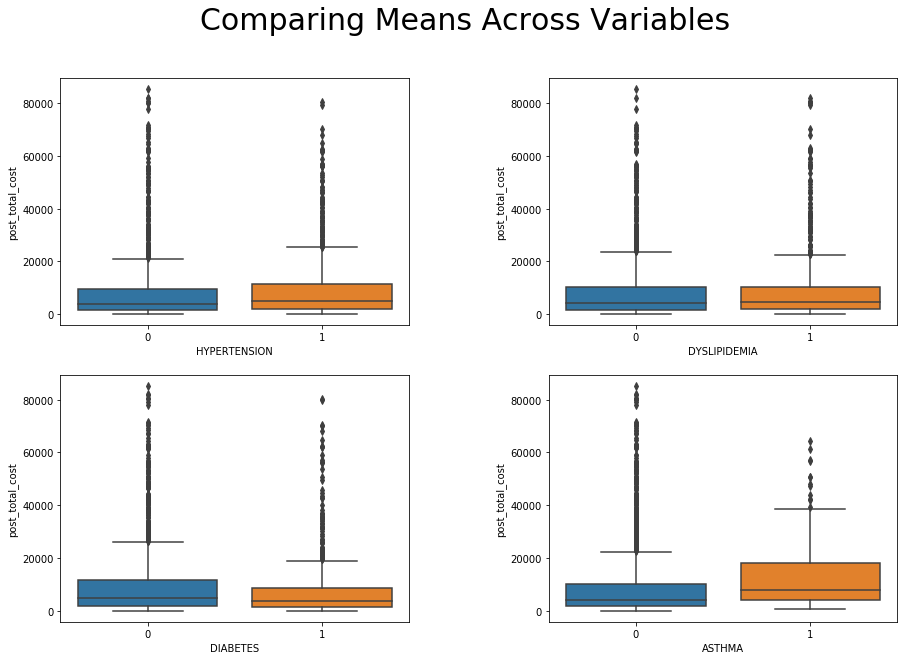

In [31]:
# Setting up the plot sizes and stuff
plt.figure(figsize=(15,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)
plt.suptitle('Comparing Means Across Variables', fontsize=30)


# Looping over 4 diseases and plotting them in the respective subplots
for dis, i in zip(['HYPERTENSION','DYSLIPIDEMIA', 'DIABETES','ASTHMA'],range(1,5)):
    plt.subplot(2,2,i)
    sns.boxplot(x=dis, y='post_total_cost', data=eda_data)


Visually, it looks like HYPERTENSION and DYSLIPIDEMIA may **NOT** be good variables to use to predict post medical cost because we can see that post total cost mean is the same for patients that have HYPERTENSION(1) and DYSLIPIDEMIA(1) and for patients that do not have HYPERTENSION(0) and DYSLIPIDEMIA(0), but we can see there DIABETES & ASTHMA may be a good variables due to a visibly significant differences in the mean. 

In order to solidify this comparision numerically, we will use two sample T Test to see if there truly is a significant difference in the means between the 0's and 1's of the categorical variables in relation to the total medical costs.

In [32]:
"""
This loops over our dataset with all the diagnoses columns and returns back the variables that have a significance level <.05,
showing us that the mean for post total cost for patients that have these diagnoses (1) is significantly different than the 
patients that do not have these diagnoses(0) 

"""
threshold = 0.05

# Empty list to append column names where P-value is less than threshold
cat_columns_chosen = []

# Looping over each categorical variable.
for column in eda_data.iloc[:,0:34]:
    
    # splitting the dataset into 0 or 1.IE: presence of categrical variable of not 
    zero = eda_data[eda_data[column]== 0]['post_total_cost']
    one = eda_data[eda_data[column]== 1]['post_total_cost']
    
    # t-test here
    ttest = stats.ttest_ind(zero , one)
    
    # get p-value 
    if ttest[1] < threshold:
        print('{}: {}'.format(column, round(ttest.pvalue,6) ))
        cat_columns_chosen.append(column)  # Categorical variables to use for predicting the post_total_cost        

ASTHMA: 0.000102
CARDIAC_ARRYTHMIA: 0.000126
CARDIAC_VALVULAR: 0.000766
CHRONIC_KIDNEY: 0.001563
CHRONIC_PAIN_FIBRO: 0.000106
CHF: 1e-06
DEMENTIA: 0.005591
DEPRESSION: 0.0
DIABETES: 9.1e-05
HEPATITIS: 0.032996
LIVER_GALLBLADDER_PANCREAS: 0.003223
MI_CAD: 0.00056
OSTEOARTHRITIS: 0.0
PERIPHERAL_VASCULAR: 0.000494
RENAL_FAILURE: 0.002152
RHEUMATOLOGIC: 0.000738
SLEEP_DISORDERS: 1e-06
SMOKING: 0.012965
THYROID: 0.024687
Solid_Tumor: 0.0
Metastatic: 0.0
Leukemia_Lymphoma: 0.004993
Other_Cancer: 0.011515


# Regression - Model Fitting

## Iteration 1

In [33]:
"""Data Cleaning & Feature Engineering

- **a.** Normalize the continuous variables
- **b.** Deal with outlier data? Cap it maybe
- **c.** Create new features if necessary

##### Normalizing the data

Here we look to employ the use of Guassian normalization techniques to pull our continuous variables, considering that they are not on the same scale
"""

def normalize(cf):
    """takes in a dataframe and normalizes it"""
    scaler = preprocessing.StandardScaler().fit(cf)
    X_scaled = scaler.transform(cf)
    a = pd.DataFrame(X_scaled)
    a.columns = cf.columns
    return a
    

In [34]:
# normalizing cont features
final_reg_scaled = normalize(final_reg)
final_reg_scaled.head(2)

# setting index
final_reg_scaled.index = final_reg.index
final_reg_scaled.head(5)

C:\Users\Darshil Desai\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Darshil Desai\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


,pre_rx_cost,pre_op_cost,pre_total_cost,num_op,num_gpi6,log_pre_op_cost,log_pre_rx_cost,pre_total_cat,brand_cost
0,0.394398,-0.321876,-0.454324,1.828715,0.025625,0.142058,0.968525,0.147669,0.932456
1,-0.208051,-0.497465,-0.633323,-0.639950,-0.467157,-0.373597,0.346919,-0.858021,-0.404607
2,-0.345854,-0.451206,-0.135515,-0.125645,1.257578,-0.167275,-0.218917,0.818128,-0.404607
3,-0.369501,-0.542232,1.580650,-0.125645,-0.220766,-0.771092,-0.486400,1.153358,-0.404607
4,0.625484,-0.218275,-0.373349,-0.228506,1.257578,0.288917,1.079760,0.482898,1.058178


In [35]:
# combining cont + cat features that are selected using the T-test above!
main_data_reg = pd.concat([final_reg_scaled, reg_categorical_vars[cat_columns_chosen]  ], axis=1)  
main_data_reg.head(5)

,pre_rx_cost,pre_op_cost,pre_total_cost,num_op,num_gpi6,log_pre_op_cost,log_pre_rx_cost,pre_total_cat,brand_cost,ASTHMA,...,PERIPHERAL_VASCULAR,RENAL_FAILURE,RHEUMATOLOGIC,SLEEP_DISORDERS,SMOKING,THYROID,Solid_Tumor,Metastatic,Leukemia_Lymphoma,Other_Cancer
0,0.394398,-0.321876,-0.454324,1.828715,0.025625,0.142058,0.968525,0.147669,0.932456,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.208051,-0.497465,-0.633323,-0.639950,-0.467157,-0.373597,0.346919,-0.858021,-0.404607,0,...,0,0,0,1,0,0,0,0,0,0
2,-0.345854,-0.451206,-0.135515,-0.125645,1.257578,-0.167275,-0.218917,0.818128,-0.404607,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.369501,-0.542232,1.580650,-0.125645,-0.220766,-0.771092,-0.486400,1.153358,-0.404607,0,...,0,0,0,0,1,0,0,0,0,0
4,0.625484,-0.218275,-0.373349,-0.228506,1.257578,0.288917,1.079760,0.482898,1.058178,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
# Splitting the dataset into training and validation data
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(main_data_reg, data.loc[main_data_reg.index]['post_total_cost'], test_size=0.20, random_state=42)

In [37]:
# Create linear regression object
regr = LinearRegression()

# Fitting the model
regr.fit(X_train_reg, np.log(y_train_reg))

# In sample RMSE error - LOG
np.sqrt(mean_squared_error(np.log(y_train_reg), regr.predict(X_train_reg)))

1.1874545412906616

In [38]:
# Outsample error:  testing the validation 
np.sqrt(mean_squared_error(np.log(y_val_reg), regr.predict(X_val_reg)))

1.299040185105841

**Conclusion of iteration 1: Interpretaing the errors**

The RMSE or root mean square error allows you to see how much your prediction deviates, on average, from the actual value in the units of the variable

- In sample real RMSE of 680: Average deviation in predicted total_medical_cost for the training dataset is $11282 (hunderds? - CHECK UNITS)

- Out sample real RMSE of 1561: Average deviation in predicted total_medical_cost for the validation dataset is $11064 (hunderds? - CHECK UNITS)

### Testing LINE Assumptions

In [39]:
def LINE_test_plot(df):
    
    """
    Performs a LINE check and returns the relevant plots
    """
    

    # combining X, Y data to use into 
    ols_train_data = df

    all_columns = "+".join([x for x in ols_train_data.columns if x != 'post_total_cost'])

    my_formula = "post_total_cost~" + all_columns
    mlr_model1 = smf.ols(my_formula, data = ols_train_data).fit()

    # Setting up the plot sizes and stuff
    plt.figure(figsize=(15,10))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)
    plt.suptitle('Checking Linear Regression Assumptions', fontsize=30)

    #-------------------------------------------
    plt.subplot(2,2,1)

    # Q-Q plot

    stats.probplot(mlr_model1.resid, plot= plt)
    plt.title("Residuals Probability Plot")

    #-------------------------------------------
    plt.subplot(2,2,2)

    residuals = abs(mlr_model1.predict(ols_train_data[[x for x in ols_train_data.columns if x != 'post_total_cost']]) - ols_train_data.post_total_cost)
    preds = mlr_model1.predict(ols_train_data[[x for x in ols_train_data.columns if x != 'post_total_cost']])


    # plotting everything for Homoesdasticity
    plt.title("Checking for Homoesdasticity")
    plt.plot(preds ,residuals, '.')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')    



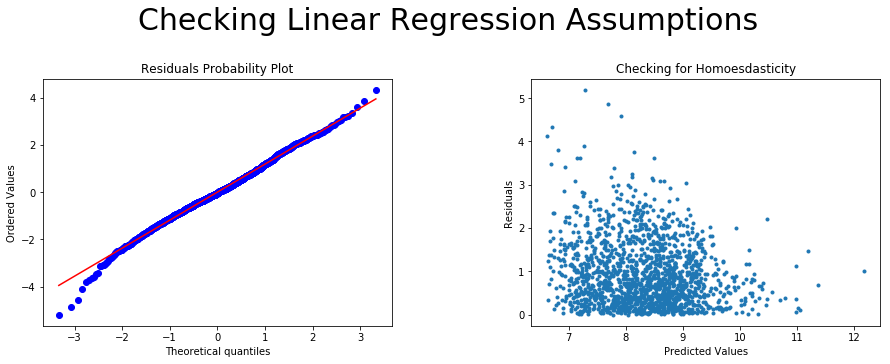

In [40]:
LINE_test_plot(pd.concat([X_train_reg,  np.log(y_train_reg) ],1))

## Iteration 2: 

- Stepwise Regression

In [41]:
stepwise_columns = stepwise_regression.forward_regression(main_data_reg, data.loc[main_data_reg.index]['post_total_cost'], threshold_in=0.05, verbose=False)
stepwise_columns

C:\Users\Darshil Desai\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


['num_op',
 'OSTEOARTHRITIS',
 'Metastatic',
 'brand_cost',
 'DIABETES',
 'CARDIAC_ARRYTHMIA',
 'DEPRESSION',
 'pre_op_cost',
 'SLEEP_DISORDERS',
 'num_gpi6',
 'CHF',
 'pre_total_cost',
 'PERIPHERAL_VASCULAR',
 'Leukemia_Lymphoma',
 'pre_rx_cost',
 'ASTHMA',
 'DEMENTIA',
 'SMOKING']

In [42]:
# Using columns from stepwise regression
stepwise_main_data_reg = main_data_reg[stepwise_columns]

# Splitting the dataset into training and validation data
X_train_reg_s, X_val_reg_s, y_train_reg_s, y_val_reg_s = train_test_split(stepwise_main_data_reg, data.loc[main_data_reg.index]['post_total_cost'], test_size=0.20, random_state=42)

In [43]:
# Create linear regression object
regr = LinearRegression()

# Fitting the model
regr.fit(X_train_reg_s, np.log(y_train_reg_s))

# In sample RMSE error - LOG
np.sqrt(mean_squared_error(np.log(y_train_reg_s), regr.predict(X_train_reg_s)))

1.2336384224301773

In [44]:
# Outsample error:  testing the validation 
np.sqrt(mean_squared_error(np.log(y_val_reg_s), regr.predict(X_val_reg_s)))

1.35563807634966

### Testing LINE Assumptions

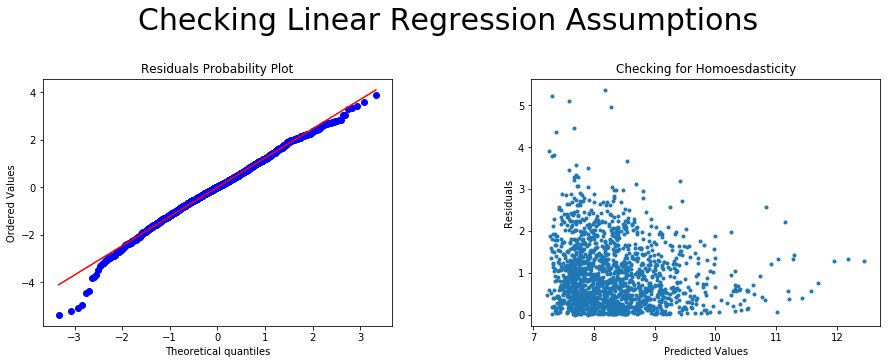

In [45]:
LINE_test_plot(pd.concat([X_train_reg_s,  np.log(y_train_reg_s) ],1))

**Conclusion:** Stepwise regression RMSE metrics are not very different from our custom model selection approach in Iteration 1. ADD MORE

# Classification - Feature Selection

This section will focus on determining the which of the appropriate features to incorporate in our model fitting. We will employ the use of various techniques to determine the following: 
    
- **(i.) Which features show significant associativity which the predictor variable we will use for classification. Predicting the pdc_80_flag variable poses as a binary classification problem. 
    - Employ the use of chi-square tests to determine which categorical variables prove to be associative with 
    - Employ the use of the Wilcoxon T-Tests to determine which continuous variables work best in predicting the pdc_80_flag

### Chi - Square tests

In [46]:
"""Co - morbidity index"""
# First we need to make a contigency table 


def chisq(cat_cols, group, a, df):    
    """
    Calculates the chi-square metric for a set of categorical variables given the group
    
    Parameters
    ----------
    : param cat_cols: The column names of categorical columns in from the data file
    : param group: Aither ANTIDIABETIC or ANTICOAGULANT or BOTH as 'ANTIDIABETIC|ANTICOAGULANT'
    : param a: alpha test statistic
    """
    
    data = df
    
    # Only retreiving rows belonging to the group
    subset_ad = data[data['drug_class'].str.contains(group)]
    
    # Initializing empty lists to append into
    var = []
    p_val = []
    

    # Iterating over each cat_column
    for x in cat_cols:
        
        # Contingency table for that categorical column and the pdc_80_flag
        table = np.array(pd.crosstab(subset_ad[x], subset_ad['pdc_80_flag']))

        # Getting statistical metrics
        stat, p, dof, expected = chi2_contingency(table)
        
        # Append all data
        var.append(x), p_val.append(p)
    
    # Empty dataframe to append into
    mod_df = pd.DataFrame({'variable': var, 'p_val': np.round(p_val,6)})

    # return
    return mod_df[mod_df['p_val'] <= a]          


In [47]:
data1 = data[data['drug_class'].str.contains('ANTIDIABETIC')]

# Which categorical columns were chosen for Diabetic patients
cat_chosen = chisq(class_categorical_vars.columns, 'ANTIDIABETIC', 0.05, df=pd.concat([class_categorical_vars, data1[['drug_class', 'pdc_80_flag']]],1)).variable
cat_chosen

11        DIABETES
12    DYSLIPIDEMIA
16    HYPERTENSION
28         THYROID
34            sexN
35       pre_CCI_0
36       pre_CCI_1
45      age_grpN_2
46      age_grpN_3
47      age_grpN_4
50       regionN_3
Name: variable, dtype: object

### Wilcoxon Test

- To choose continous features for classification

In [48]:
# Creating a seperate dataframe with continous features for classification along with drug_class and pdc_80_flag
df_wilcox = pd.concat([class_cont_vars, data1[['drug_class', 'pdc_80_flag']]],1)

# Splitting it into two datasets PDC_80_Flag 0 and 1
df_wilcox_0 = df_wilcox[df_wilcox['pdc_80_flag']==0]
df_wilcox_1 = df_wilcox[df_wilcox['pdc_80_flag']==1]


#Randomly selecting N rows for the Wilcoxon test
np.random.seed(3)
N = 300
df_wilcox_0_r = df_wilcox_0.loc[np.random.choice(df_wilcox_0.index,N)]
df_wilcox_1_r = df_wilcox_1.loc[np.random.choice(df_wilcox_1.index,N)]


# Performing the Wilxocon Test here 

    # Empty list for continous columns to use for classification
cont_cols_use = []

for column, p_value in zip( class_cont_vars.columns, [stats.wilcoxon(df_wilcox_0_r[x],df_wilcox_1_r[x])[1] for x in class_cont_vars.columns]):
    if p_value < 0.05:    
        print ('{}: {}'.format(column, p_value)), cont_cols_use.append(column)                

pdc: 6.060309350527707e-51
pdc_cat: 6.760813950869273e-29
pre_er_cost: 0.02480080595225188
pre_rx_cost: 0.0001248457641211887
num_ndc: 1.5935035583241227e-06
num_gpi6: 0.000483096741248662
adjust_total_30d: 8.176776148652972e-08
log_pre_rx_cost: 8.292802336371263e-07
numofgen: 3.321468002211197e-06
numofbrand: 0.009980112535512039
generic_cost: 3.879276859404366e-08
brand_cost: 0.011234916593773509
ratio_G_total_cost: 0.00014248644587522305


C:\Users\Darshil Desai\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2781: RuntimeWarning: invalid value encountered in greater
  r_plus = np.sum((d > 0) * r, axis=0)
C:\Users\Darshil Desai\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2782: RuntimeWarning: invalid value encountered in less
  r_minus = np.sum((d < 0) * r, axis=0)


# Classification - Model Fitting

Prior to model fitting, we will create the combined dataset and then split it up the training dataset into training and validation sets in order to test for hyperparameters

In [49]:
# categorical features for classification
cat_features_classification = class_categorical_vars[cat_chosen]

# cont features fr classification
cont_features_classification = normalize(class_cont_vars[cont_cols_use])
cont_features_classification.index = cat_features_classification.index  # Setting the correct indices again

C:\Users\Darshil Desai\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Darshil Desai\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


In [50]:
"""Combined dataset"""
main_x = pd.concat([cont_features_classification, cat_features_classification], axis=1)
main_x = main_x.dropna()

In [51]:
# Splitting the dataset into training and validation
X_train, X_val, y_train, y_val = train_test_split(main_x, data1.loc[list(main_x.index)]['pdc_80_flag'], test_size=0.20, random_state=42)

In [52]:
def return_accu_report(Xval, yval,Xtrain,ytrain, model):
    """
    returns the in and out sample accuracy rates
    """
    preds_log = model.predict(X_val)
    
    # In sample---------------------------
    # Accuracy
    in_sample_accuracy = round(accuracy_score(ytrain ,model.predict(Xtrain)),2) *100
    # Testing
    print ('The in sample accuracy score using this classifier: {} %'.format(in_sample_accuracy))

    
    
    # Out sample ----------------------
    out_preds = model.predict(Xval)
    
    # Accuracy
    out_sample_accu = round(accuracy_score(yval ,out_preds),2) *100
    # Testing
    print ('The out sample accuracy score using this classifier: {} %'.format(out_sample_accu))

    
    # Confusion matrix for the out sample
    print ('Confusion Matrix: \n' ,confusion_matrix(y_val , out_preds))

### (NB) Classification Using Naive Bayes 

In this section we will employ the use of the Naive Bayes Classifer to predict the pdc_80_flag. Particularily:

- Categorical features used: DIABETES, DYSLIPIDEMIA, HYPERTENSION, THYROID, age_grpN, sexN, regionN
- Continous features used: All for now (will delete later after the statistical section above is filled)

In [53]:
#Create a Gaussian Classifier
nb_model = GaussianNB()

# Fitting the Model
nb_model.fit(X_train,y_train)

return_accu_report(X_val, y_val,X_train, y_train, nb_model)    

The in sample accuracy score using this classifier: 100.0 %
The out sample accuracy score using this classifier: 99.0 %
Confusion Matrix: 
 [[112   0]
 [  1  72]]


### (LR) Logistic Regression

In this section we will employ the use of the Logistic Regression Classifer to predict the pdc_80_flag. Particularily:

- Categorical features used: DIABETES, DYSLIPIDEMIA, HYPERTENSION, THYROID, age_grpN, sexN, regionN
- Continous features used: All for now (will delete later after the statistical section above is filled)

In [54]:
# creating an instance of the model AND fitting it 
log_model = LogisticRegression(random_state=0, penalty="l2", max_iter = 1000, solver = 'lbfgs')

# Fitting the Model
log_model.fit(X_train,y_train)

return_accu_report(X_val, y_val,X_train, y_train, log_model)    

The in sample accuracy score using this classifier: 100.0 %
The out sample accuracy score using this classifier: 100.0 %
Confusion Matrix: 
 [[112   0]
 [  0  73]]


### (KNN) K - Nearest Neighbors

In this section we will employ the use of the KNN to predict the pdc_80_flag. Particularily:

- Categorical features used: DIABETES, DYSLIPIDEMIA, HYPERTENSION, THYROID, age_grpN, sexN, regionN
- Continous features used: All for now (will delete later after the statistical section above is filled)

In [55]:
# Initializing the model
neigh = KNeighborsClassifier(n_neighbors=3, weights = 'distance')

# fitting the model 
neigh.fit(X_train, y_train)

return_accu_report(X_val, y_val,X_train, y_train, neigh)    

The in sample accuracy score using this classifier: 100.0 %
The out sample accuracy score using this classifier: 96.0 %
Confusion Matrix: 
 [[108   4]
 [  4  69]]


# Test & Deploy
- For Prof.Zarei

In this section we will facilitate the use of an external dataset (with the same features) to test the models we have created above on new data. 

**PENDING** until we figure our final models and consequentially the features